## Imports etc.

In [4]:
import os

import timm
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from lib.utils.pre_train import get_configs
from lib.utils.misc import WrappedModel
from lib.dataset.cataracts_dataset import CATARACTSDataset

## Load configs

In [5]:
DATA_PATH = '/media/yannik/samsung_data_ssd/data/CATARACTS-videos-processed/'
LOG_PATH = 'results/tool_classifier_resnet50/2023.02.28 07_50_36/'  # Trained on real training data
# LOG_PATH = 'results/simple_tool_classifier_synth/2023.03.04 22_46_39/'  # Trained solely on synthetic data (For CAS scores)
# LOG_PATH = 'results/simple_tool_classifier_extended/2023.03.05 20_06_33/'  # Trained on combination of real and synthetic data
TARGET_PATH = os.path.join(LOG_PATH, "eval/")
DEV = 'cuda'
data_conf, model_conf, diffusion_conf, train_conf = get_configs(LOG_PATH + "config.yaml")
os.makedirs(TARGET_PATH, exist_ok=True)
STEPS = 1
BATCH_SIZE = 32  # 64
print(f"Avail. GPUs: ", torch.cuda.device_count())

Avail. GPUs:  1


## Load data

In [6]:
from torch.utils.data import ConcatDataset

test_ds = CATARACTSDataset(
    root=DATA_PATH,
    resize_shape=eval(data_conf['SHAPE'])[1:],
    normalize=eval(data_conf['NORM']),
    mode='test',
    # frame_step=data_conf['FRAME_STEP'],
    frame_step=1,
    sample_img=True
)

val_ds = CATARACTSDataset(
    root=DATA_PATH,
    resize_shape=eval(data_conf['SHAPE'])[1:],
    normalize=eval(data_conf['NORM']),
    mode='val',
    # frame_step=data_conf['FRAME_STEP'],
    frame_step=1,
    sample_img=True
)

# TODO: Weighted sampling / sampling from p(toolset|phase)
dl = DataLoader(ConcatDataset([test_ds, val_ds]), batch_size=BATCH_SIZE, num_workers=8, drop_last=True, shuffle=True, pin_memory=False)
print(f"{len(test_ds)} samples")

177464 samples


## Load model

In [7]:
match model_conf['TYPE'].upper():
    case 'INCEPTIONV4':
        m = timm.create_model('inception_v4',
                              pretrained=True,
                              num_classes=test_ds.dataset.num_tool_classes).to(DEV)
    case 'RESNET18':
        m = timm.create_model('resnet18',
                              pretrained=True,
                              num_classes=test_ds.dataset.num_tool_classes).to(DEV)
    case 'RESNET50':
        m = timm.create_model('resnet50',
                              pretrained=True,
                              num_classes=test_ds.dataset.num_tool_classes).to(DEV)
    case _:
        raise NotImplementedError
m = torch.nn.DataParallel(m, device_ids=[DEV]) if not DEV == 'cpu' else WrappedModel(m)
try:
    m.load_state_dict(torch.load(LOG_PATH + "ckpt.pth", map_location='cpu')[0])
except:
    m.module.load_state_dict(torch.load(LOG_PATH + "ckpt.pth", map_location='cpu')[0])
m.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, 

In [8]:
import gc

import torch
from torchmetrics.functional import f1_score, auroc, accuracy

from lib.utils.misc import label_vectors_to_names

gc.collect()
torch.cuda.empty_cache()

## Test performance

In [19]:
with torch.no_grad():
    for i, (img, _, file_name, phase_label, tool_label) in enumerate(tqdm(dl)):

        if i == 1:
            break

        img, tool_label = img.to(DEV), tool_label.to(DEV)

        pred = torch.sigmoid(m(img))

        for n in range(BATCH_SIZE):
            print(phase_label[n].shape)
            print(tool_label[n].shape)
            print(pred[n].shape)

  0%|          | 1/7234 [00:01<2:19:01,  1.15s/it]

torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])
torch.Size([1])
torch.Size([21])
torch.Size([21])


  0%|          | 1/7234 [00:01<3:31:16,  1.75s/it]


In [20]:
test_targets = None
test_predictions = None

test_phase_wise_targets = [None] * test_ds.num_phases_classes
test_phase_wise_predictions = [None] * test_ds.num_phases_classes
tool_count, no_tool_count = [0] * test_ds.num_phases_classes, [0]*test_ds.num_phases_classes

with torch.no_grad():
    for i, (img, _, file_name, phase_label, tool_label) in enumerate(tqdm(dl)):

        phase_label = phase_label.int()

        img, tool_label = img.to(DEV), tool_label.to(DEV)

        pred = torch.sigmoid(m(img))

        """
        for n in range(BATCH_SIZE):
            # TODO: pred to int by thresholding
            pred_n_int = (pred[n] > .5).int()
            print("Prediction: ", label_vectors_to_names(test_ds, None, pred_n_int)[1])
            print("Target: ", label_vectors_to_names(test_ds, None, tool_label[n])[1])
            print()
        """

        test_targets = tool_label if test_targets is None else torch.cat([test_targets, tool_label], dim=0)
        test_predictions = pred if test_predictions is None else torch.cat([test_predictions, pred], dim=0)

        for n in range(BATCH_SIZE):
            phase_id_n = phase_label[n].item()
            if (tool_label[n] == 0.).all():
                no_tool_count[phase_id_n] += 1
            else:
                tool_count[phase_id_n] += 1
            test_phase_wise_targets[phase_id_n] = tool_label[n:n+1] if test_phase_wise_targets[phase_id_n] is None \
                else torch.cat([test_phase_wise_targets[phase_id_n], tool_label[n:n+1]], dim=0)
            test_phase_wise_predictions[phase_id_n] = pred[n:n+1] if test_phase_wise_predictions[phase_id_n] is None \
                else torch.cat([test_phase_wise_predictions[phase_id_n], pred[n:n+1]], dim=0)

print("F1 Score: ", f1_score(test_predictions, test_targets, task='binary', threshold=0.5))
print("AUROC: ", auroc(test_predictions, test_targets, task='binary'))
print("Accuray: ", accuracy(test_predictions, test_targets, task='binary', threshold=0.5))

100%|██████████| 7234/7234 [40:15<00:00,  2.99it/s]


F1 Score:  tensor(0.8908, device='cuda:0')
AUROC:  tensor(0.9853, device='cuda:0')
Accuray:  tensor(0.9922, device='cuda:0')


## Plotting

########## ---------- Idle
F1 Score:  0.3845535218715668
AUROC:  0.9352907538414001
Accuray:  0.9971266984939575
########## ---------- Toric Marking
F1 Score:  0.0
AUROC:  0.15150730311870575
Accuray:  0.9503931999206543
########## ---------- Implant Ejection
F1 Score:  0.5021803379058838
AUROC:  0.896589457988739
Accuray:  0.9461492896080017
########## ---------- Incision
F1 Score:  0.8148011565208435
AUROC:  0.987757682800293
Accuray:  0.9897398352622986
########## ---------- Viscodilatation
F1 Score:  0.723398745059967
AUROC:  0.9720578193664551
Accuray:  0.981338620185852
########## ---------- Capsulorhexis
F1 Score:  0.9179216623306274
AUROC:  0.9974364042282104
Accuray:  0.9931383728981018
########## ---------- Hydrodissection
F1 Score:  0.8945823311805725
AUROC:  0.9965035319328308
Accuray:  0.9924821853637695
########## ---------- Nucleus Breaking
F1 Score:  0.965890109539032
AUROC:  0.9975283741950989
Accuray:  0.9957966208457947
########## ---------- Phacoemulsification
F1 Sc

/home/yannik/anaconda3/envs/cat_diff/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


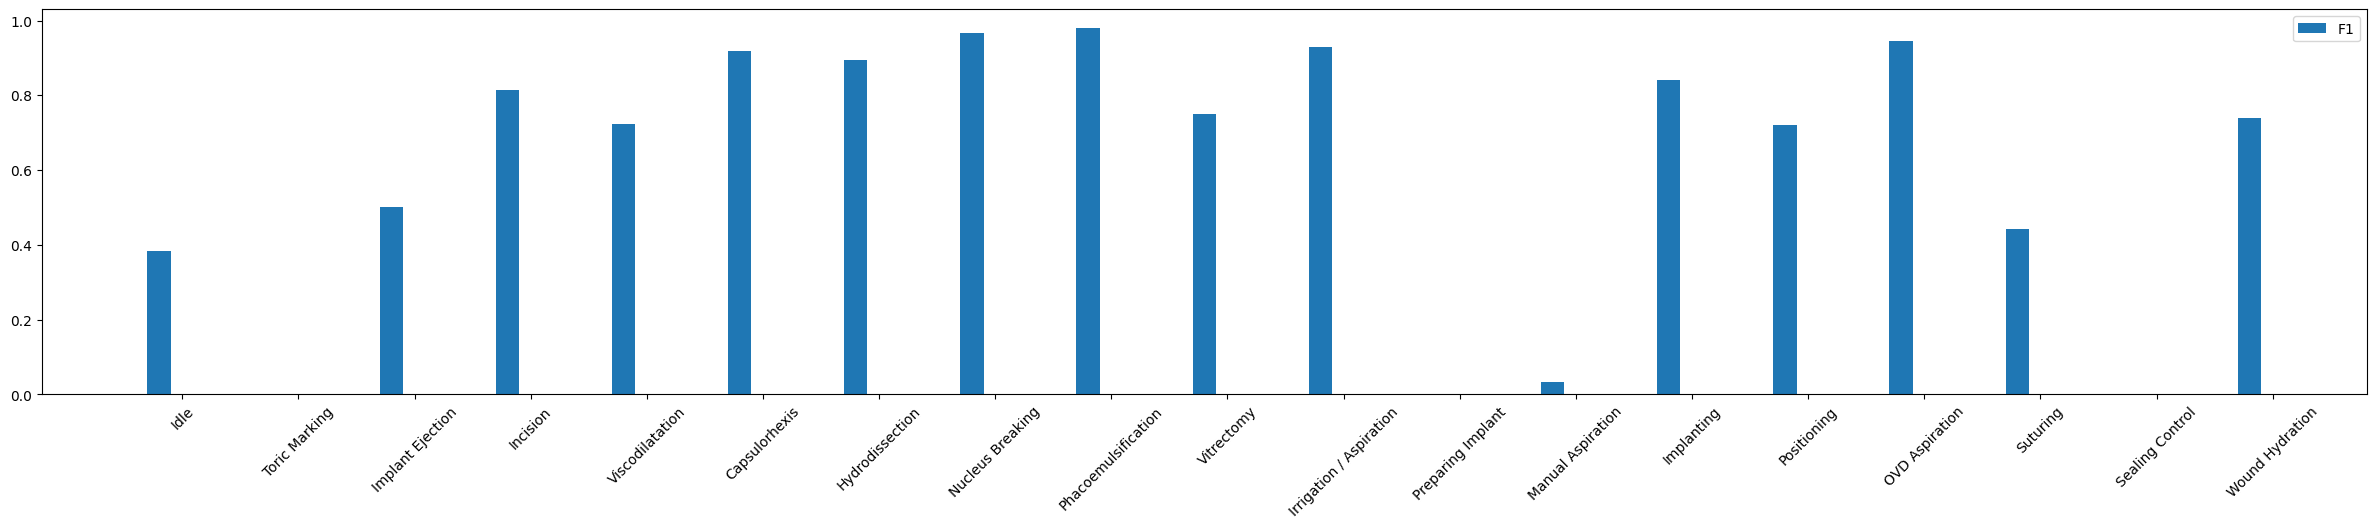

In [21]:
import matplotlib.pyplot as plt
import numpy as np
f1_score_per_phase = [0]*len(test_ds.phase_label_names)
auroc_per_phase = [0]*len(test_ds.phase_label_names)
acc_per_phase = [0]*len(test_ds.phase_label_names)
plt.figure(figsize=(30, 5))
for phase_id, phase_name in enumerate(test_ds.phase_label_names):
    print(f"########## ---------- {phase_name}")

    preds = test_phase_wise_predictions[phase_id]
    targs = test_phase_wise_targets[phase_id].int()
    #preds = val_phase_wise_predictions[phase_id]
    #targs = val_phase_wise_targets[phase_id]

    f1 = f1_score(preds, targs).item()
    aur = auroc(preds, targs, task='binary').item()
    acc = accuracy(preds, targs).item()
    print("F1 Score: ", f1)
    print("AUROC: ", aur)
    print("Accuray: ", acc)
    f1_score_per_phase[phase_id] = f1
    auroc_per_phase[phase_id] = aur
    acc_per_phase[phase_id] = acc
#plt.bar(x=test_ds.phase_label_names, width=0.3, height=f1_score_per_phase, label='F1')
#plt.bar(x=test_ds.phase_label_names, width=0.3, height=auroc_per_phase, label='AUROC')
#plt.bar(x=test_ds.phase_label_names, width=0.3, height=acc_per_phase, label='F1')
plt.bar(x=np.arange(0, test_ds.num_phases_classes) - .2, width=0.2, height=f1_score_per_phase, label='F1')
#plt.bar(x=np.arange(0, test_ds.num_phases_classes) , width=0.2, height=auroc_per_phase, label='AUROC')
#plt.bar(x=np.arange(0, test_ds.num_phases_classes) + .2, width=0.2, height=acc_per_phase, label='Acc.')
plt.legend()
plt.xticks(ticks=np.arange(0, test_ds.num_phases_classes), labels=test_ds.phase_label_names, rotation = 45)
plt.autoscale()
# plt.savefig('plots/val_set_phase_wise_performance.svg', format='svg', bbox_inches='tight')
# plt.savefig('plots/test_set_phase_wise_performance.svg', format='svg', bbox_inches='tight')
plt.show()

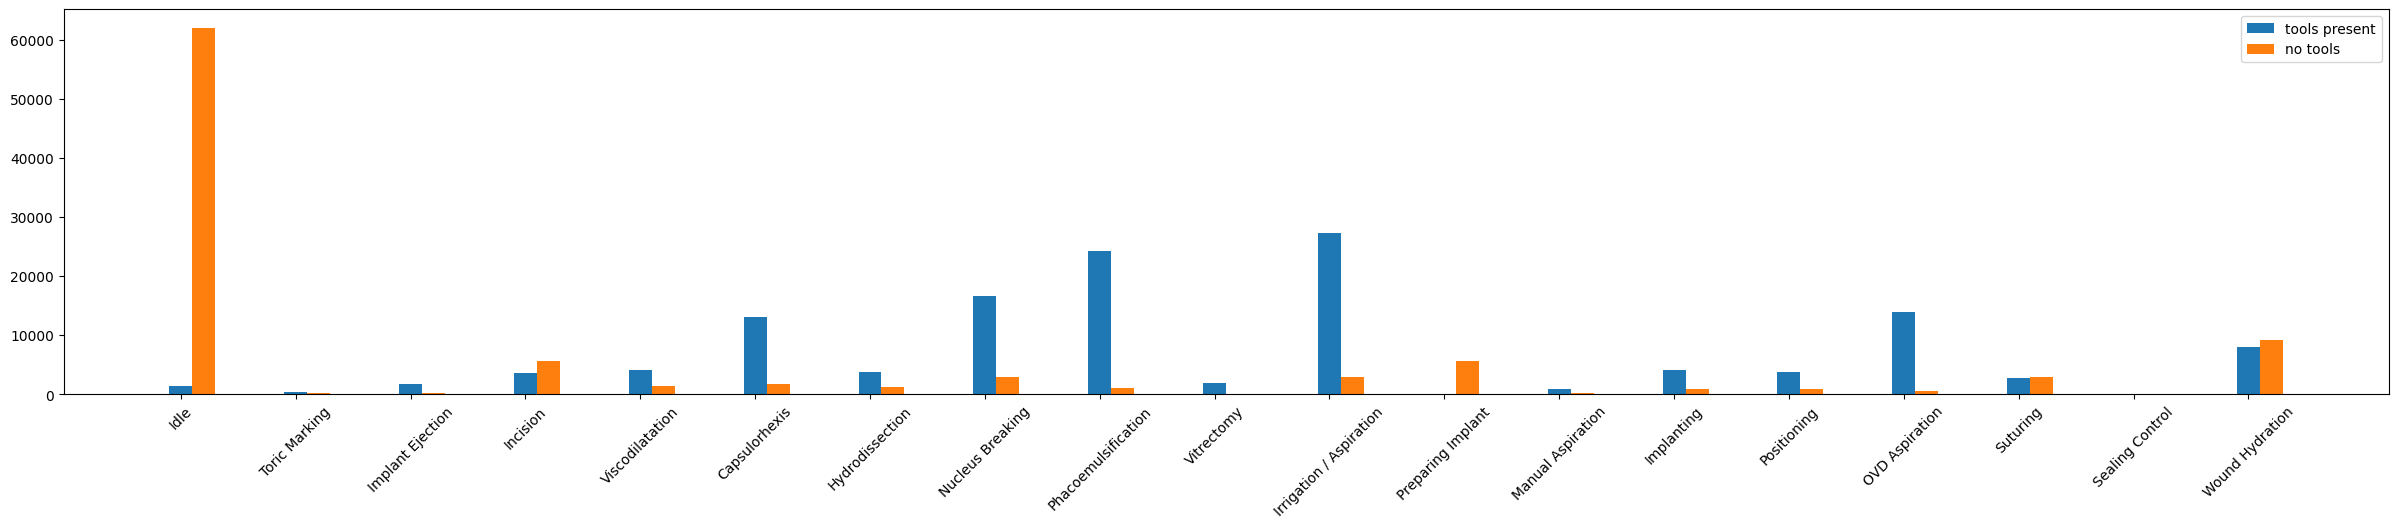

In [22]:
plt.figure(figsize=(30, 5))
plt.bar(x=np.arange(0, test_ds.num_phases_classes), width=0.2, height=tool_count, label='tools present')
plt.bar(x=np.arange(0, test_ds.num_phases_classes) + .2, width=0.2, height=no_tool_count, label='no tools')
plt.legend()
plt.xticks(ticks=np.arange(0, test_ds.num_phases_classes), labels=test_ds.phase_label_names, rotation = 45)
plt.autoscale()
plt.show()

## F1 score per tool per phase

In [28]:
for phase_id, phase_name in enumerate(test_ds.phase_label_names):
    print(f"\n########## ---------- {phase_name}")
    preds = test_phase_wise_predictions[phase_id]
    targs = test_phase_wise_targets[phase_id].int()
    f1 = f1_score(preds, targs, num_classes=test_ds.num_tool_classes, top_k=3, average=None)
    for tool_id, tool_name in enumerate(test_ds.tool_label_names):
        print(f"{tool_name} F1: {f1[tool_id].item()}")



########## ---------- Idle
Biomarker F1: nan
Charleux Cannula F1: 0.36962366104125977
Hydrodissection Cannula F1: 0.019526848569512367
Rycroft Cannula F1: 0.0014404032845050097
Viscoelastic Cannula F1: 0.006861469242721796
Cotton F1: 0.0
Capsulorhexis Cystotome F1: 0.0015564202331006527
Bonn Forceps F1: 0.0
Capsulorhexis Forceps F1: 0.0007824726053513587
Troutman Forceps F1: 0.0018136476865038276
Needle Holder F1: 0.0
Irrigation/Aspiration Handpiece F1: 0.023255812004208565
Phacoemulsifier Handpiece F1: 0.1788535863161087
Vitrectomy Handpiece F1: 0.0
Implant Injector F1: 0.00338962534442544
Primary Incision Knife F1: 0.0
Secondary Incision Knife F1: 0.0007636826485395432
Micromanipulator F1: 0.2795460820198059
Suture Needle F1: 0.0
Mendez Ring F1: nan
Vannas Scissors F1: 0.0

########## ---------- Toric Marking
Biomarker F1: 0.0
Charleux Cannula F1: 0.0
Hydrodissection Cannula F1: 0.0
Rycroft Cannula F1: 0.0
Viscoelastic Cannula F1: 0.0
Cotton F1: nan
Capsulorhexis Cystotome F1: 0.0
B